# Synthetic car images

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import sys
sys.path.append('../')

from utils import repeat_n_times, hsv_to_name, create_image_embeddings
import utils
import clip

import torch
import numpy as np
from glob import glob
import pandas as pd
import webcolors
import os

In [4]:
# Hyperparameters
num_repetitions = 5
num_images = 1000

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Creating embeddings for all model sizes

In [6]:
image_paths = glob("../data/synthetic/cars/*.png")
image_paths = sorted(image_paths, key=lambda x: int(x.split("/")[-1].split(".")[0]))
image_paths = image_paths[:num_images]

image_ids = [int(p.split("/")[-1].replace(".png", "")) for p in image_paths]

In [7]:
# Uncomment each one of the following three lines separately and run the notebook to compute all results
vit_name = "ViT-B/32"
# vit_name = "ViT-B/16"
# vit_name = "ViT-L/14"

name_to_identifier = {
    "ViT-B/32": "vit-b-32",
    "ViT-B/16": "vit-b-16",
    "ViT-L/14": "vit-l-14",
}

include_models = ["pca"]

In [8]:
utils.model, utils.preprocess = clip.load(vit_name, device=device)

In [9]:
# create_image_embeddings(image_paths, image_ids, f"clip_size_results/{name_to_identifier[vit_name]}_image_embeddings.pt")

# Loading Embeddings

In [10]:
# load image features and labels
image_features = torch.load(f"clip_size_results/{name_to_identifier[vit_name]}_image_embeddings.pt")
df = pd.read_csv("../data/synthetic/cars.csv")
df = df[df["frame"] <= num_images]

In [11]:
image_features = [image_features[i] for i in range(1, num_images + 1)]
image_features = torch.tensor(np.stack(image_features, axis=0))

In [12]:
df.sort_values(by="frame", inplace=True)

# Experiments

## Car Model

In [12]:
# # Scrapes all car model names from the kbb page
# car_models = pd.read_html("https://www.kbb.com/car-make-model-list/new/view-all/make/")
# all_models = car_models[0]["Make"] + " " + car_models[0][".css-1mzj64w-ContentWrapper{margin:10px 24px 10px 0px;}Model"]
# all_models = all_models.dropna().tolist()
# all_models = list(set(all_models))

In [13]:
all_models = torch.load("../data/cars196/all_models_scraped_kbb_2022-08-17.pt")

In [14]:
labels = df["model"].tolist()
texts = [f"a photo of a {m}" for m in all_models]

path = f"clip_size_results/model_{name_to_identifier[vit_name]}.pt"

means, stds = repeat_n_times(num_repetitions, labels, image_features, texts=texts, include_models=include_models)

# if we already have results, just concatenate the new columns    
if os.path.exists(path):
    data = torch.load(path)
    means_old = data["means"]
    stds_old = data["stds"]
    means = pd.concat([means_old, means], axis="columns")
    stds = pd.concat([stds_old, stds], axis="columns")

torch.save({"model": vit_name, "means": means, "stds": stds}, path)

Creating text features
Run 1
Getting PCA performance
Run 2
Getting PCA performance
Run 3
Getting PCA performance
Run 4
Getting PCA performance
Run 5
Getting PCA performance


## Car Color

In [15]:
df["color_name"] = df.apply(hsv_to_name, axis=1, hue_column="color_hue", sat_column="color_sat", val_column="color_val")

In [16]:
labels = df["color_name"].tolist()
texts = [f"a {c} car" for c in webcolors.CSS21_HEX_TO_NAMES.values()]

path = f"clip_size_results/car_color_{name_to_identifier[vit_name]}.pt"

means, stds = repeat_n_times(num_repetitions, labels, image_features, texts=texts, include_models=include_models)

# if we already have results, just concatenate the new columns    
if os.path.exists(path):
    data = torch.load(path)
    means_old = data["means"]
    stds_old = data["stds"]
    means = pd.concat([means_old, means], axis="columns")
    stds = pd.concat([stds_old, stds], axis="columns")

torch.save({"model": vit_name, "means": means, "stds": stds}, path)

Creating text features
Run 1
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 2
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 3
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 4
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 5
Getting PCA performance
PCA failed, but proceed with None for all metrics


## Background Color

In [12]:
df["bg_color_name"] = df.apply(hsv_to_name, axis=1, hue_column="bg_color_hue", sat_column="bg_color_sat", val_column="bg_color_val")

In [13]:
labels = df["bg_color_name"].tolist()
texts = [f"a car in front of a {c} background" for c in webcolors.CSS21_HEX_TO_NAMES.values()]

path = f"clip_size_results/bg_color_{name_to_identifier[vit_name]}.pt"

means, stds = repeat_n_times(num_repetitions, labels, image_features, texts=texts, include_models=include_models)

# if we already have results, just concatenate the new columns    
if os.path.exists(path):
    data = torch.load(path)
    means_old = data["means"]
    stds_old = data["stds"]
    means = pd.concat([means_old, means], axis="columns")
    stds = pd.concat([stds_old, stds], axis="columns")

torch.save({"model": vit_name, "means": means, "stds": stds}, path)

Creating text features
Run 1
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 2
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 3
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 4
Getting PCA performance
PCA failed, but proceed with None for all metrics
Run 5
Getting PCA performance
PCA failed, but proceed with None for all metrics


# Cleaning up
If we have run the same model multiple times, only use the first occurrence in the files.

In [13]:
for i, identifier in enumerate(["model", "car_color", "bg_color"]):
    files = glob(f"clip_size_results/{identifier}_*.pt")
    
    for f in files:
        data = torch.load(f)
        
        data["means"] = data["means"].loc[:, ~data["means"].columns.duplicated()]
        data["stds"] = data["stds"].loc[:, ~data["stds"].columns.duplicated()]

        torch.save(data, f)

# Visualization

In [14]:
import sys
sys.path.append('..')
from utils import model_to_name

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib
from brokenaxes import brokenaxes

plt.style.use(['science'])

In [16]:
def catch(func, handler):
    try:
        return func()
    except Exception as e:
        return handler(e)

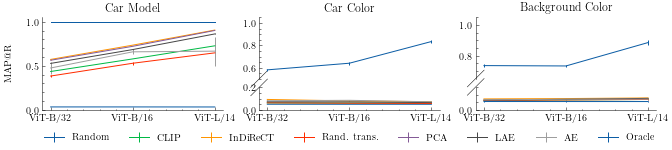

In [18]:
plt.figure(figsize=(11, 1.7))
specs = GridSpec(1, 3)

idents = [("Car Model", "model"), ("Car Color", "car_color"), ("Background Color", "bg_color")]
splits = [((0.0, 1.05),), ((0.0, 0.2), (0.5, 1.05)), ((0.0, 0.15), (0.65, 1.05))]

for i, ((name, identifier), split) in enumerate(zip(idents, splits)):
    bax = brokenaxes(ylims=split, subplot_spec=specs[i])

    vit_models = ["ViT-B/32", "ViT-B/16", "ViT-L/14"]
    data = [torch.load(f"clip_size_results/{identifier}_{name_to_identifier[vit_name]}.pt") for vit_name in vit_models]

    metric = "mean_average_precision_at_r"

    for model in ["Random", "CLIP", "\model", "Rand. transform", "PCA", "Linear Autoencoder", "AE", "Oracle"]:
        means = np.array([a for d in data if (a:=catch(lambda: d["means"][model][metric], lambda e: None)) is not None])
        stds = np.array([a for d in data if (a:=catch(lambda: d["stds"][model][metric], lambda e: None)) is not None])
        x = np.arange(len(means))
        
        bax.errorbar(x, means, yerr=stds, label=model_to_name.get(model, model))

    bax.set_title(name)
    bax.set_xticks(x, vit_models)

    if i == 0:
        bax.set_ylabel("MAP@R")

    if i == 1:
        bax.legend(loc="lower center", ncol=8, bbox_to_anchor=(0.5, -0.45))


plt.savefig(f"clip_size_results/synthetic_cars.pdf", bbox_inches="tight")
plt.show()